In [1]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import crystalball
from scipy.optimize import curve_fit,Bounds
import zfit_physics as zphysics
import zfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import mplhep
import uncertainties as unc
plt.style.use('belle2')
#%jsroot on

#%run functins.ipynb

2024-08-25 19:12:06.362013: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 19:12:06.393611: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 19:12:06.394786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-25 19:12:07.969776: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warnin

In [2]:
file_bkg="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/Bpeepi04Streams.root"
file_signal="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/Bpeepi0200000.root"


In [3]:
class trimVars():
    @staticmethod
    def trimCosTheta_L(df, Btree, pi, ll, q2):
        if int(Btree) == 511:
            if q2 == 1:
                df = df.query('abs(cosTheta_L) < 0.75')
            if q2 == 4:
                df = df.query('abs(cosTheta_L) < 0.95')
        
        if int(Btree) == 521:
            if pi == 'pip':
                if q2 == 1:
                    df = df.query('abs(cosTheta_L) < 0.75')
                elif q2 == 4:
                    df = df.query('abs(cosTheta_L) < 0.95')
            if pi =='pi0':
                if q2 == 1:
                    df = df.query('abs(cosTheta_L) < 0.75')
                elif q2 != 4:
                    df = df.query('abs(cosTheta_L) < 0.9')
        return df
    
    @staticmethod
    def trimCosTheta_K(df, Btree, pi, ll, q2):
        if int(Btree) == 511:
            if q2 == 1:
                df = df.query('cosTheta_K > -0.9')
            elif q2 != 4:
                df = df.query('cosTheta_K > -0.9')
            else:
                df = df.query('abs(cosTheta_K) < 0.95')
                
        if int(Btree) == 521:
            if q2 == 1:
                if pi == 'pip':
                    df = df.query('cosTheta_K > -0.9')
                else:
                    df = df.query('cosTheta_K > 0.9')
            elif q2 != 4:
                if pi == 'pip':
                    df = df.query('cosTheta_K > -0.9')
                elif pi == 'pi0':
                    df = df.query('cosTheta_K > -0.9')
                    
            elif q2 == 4:
                if pi == 'pip':
                    df = df.query('abs(cosTheta_K) > -0.95')
                if pi == 'pi0':
                    df = df.query('abs(cosTheta_K) < 0.9')
        return df
    
    @staticmethod
    def trimmers(df, Btree, pi, ll, q2):
        df = trimVars.trimCosTheta_L(df, Btree, pi, ll, q2)
        df = trimVars.trimCosTheta_K(df, Btree, pi, ll, q2)
        return df

def process_MC_data_combined(file_path_signal, file_path_background, particle_type, Btree, pi, ll, q2):
    def process_mc_data(file_path, q2):
        df = uproot.open(f"{file_path}:rec521")
        df = df.arrays(library='pd')
        mc_data = trimVars.trimmers(df, Btree, pi, ll, q2)
        mc_cut = mc_data.query('NNPass==1')
        mc_cut_best_candidate = mc_cut.query('bestCandidate == 1')
        return mc_cut_best_candidate

    mc_cut_best_candidate_signal = process_mc_data(file_path_signal, q2)
    mc_cut_best_candidate_background = process_mc_data(file_path_background, q2)

    if q2 == 11 or q2 == 12:
        mc_q2cut_background = mc_cut_best_candidate_background.query(f"q2reg == {q2}")

        if particle_type == 'ele':
            cut = f"lm_genMotherPDG == {443 if q2 == 11 else 100443} and lp_genMotherPDG == {443 if q2 == 11 else 100443} and abs(Kst_genMotherPDG) == 521 and Kst_isSignal == 1 and abs(lm_PDG) == 11 and abs(lp_PDG) == 11 and lm_genMotherPDG_1 == Kst_genMotherPDG"
        elif particle_type == 'mu':
            cut = f"lm_genMotherPDG == {443 if q2 == 11 else 100443} and lp_genMotherPDG == {443 if q2 == 11 else 100443} and abs(Kst_genMotherPDG) == 521 and Kst_isSignal == 1 and abs(lm_PDG) == 13 and abs(lp_PDG) == 13 and lm_genMotherPDG_1 == Kst_genMotherPDG"
        else:
            raise ValueError(f"Unknown particle_type: {particle_type}")

        deltaE_range = (-0.15, 0.15)

        mc_signal_q2cut_jpsi_kst_wot_filter = mc_q2cut_background.query(cut)
        mc_signal_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst_wot_filter.query('deltaE >= @deltaE_range[0] and deltaE <= @deltaE_range[1]')

        mc_bkg_q2cut_jpsi_kst_wot_filter = mc_q2cut_background.query(f'not ({cut})')
        mc_bkg_q2cut_jpsi_kst = mc_bkg_q2cut_jpsi_kst_wot_filter.query('deltaE >= @deltaE_range[0] and deltaE <= @deltaE_range[1]')
        

        mc_signal_weight_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]
        mc_bkg_weight_q2cut_jpsi_kst = mc_bkg_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]
        

        # Data
        mc_signal_data = mc_signal_q2cut_jpsi_kst
        mc_bkg_data = mc_bkg_q2cut_jpsi_kst
        
        # Weight Data
        mc_signal_weight = mc_signal_weight_q2cut_jpsi_kst
        mc_bkg_weight = mc_bkg_weight_q2cut_jpsi_kst
        

        return mc_signal_data, mc_bkg_data, mc_signal_weight, mc_bkg_weight
        
    else:
        if q2 in [1, 2, 3, 4]:
            excluded_q2reg_values = [11, 12]
            mc_q2cut_signal = mc_cut_best_candidate_signal.query(f"q2reg == {q2}")
            mc_q2cut_background = mc_cut_best_candidate_background.query(f"q2reg == {q2}")
        elif q2 == 0:
            included_q2reg_values = [1, 2, 3, 4]
            excluded_q2reg_values = [11, 12]
            mc_q2cut_signal = mc_cut_best_candidate_signal.query(f'q2reg in {included_q2reg_values} and q2reg not in {excluded_q2reg_values}')
            mc_q2cut_background = mc_cut_best_candidate_background.query(f'q2reg in {included_q2reg_values} and q2reg not in {excluded_q2reg_values}')
        else:
            raise ValueError("Invalid q2 value")

        deltaE_range = (-0.15, 0.15)

        mc_particle_type_signal = mc_q2cut_signal.query('deltaE >= @deltaE_range[0] and deltaE <= @deltaE_range[1]')
        mc_particle_type_only_signal = mc_particle_type_signal.query('isSignal==1')
        mc_particle_type_scf = mc_particle_type_signal.query('isSignal==0')

        mc_particle_type_bkg = mc_q2cut_background.query('deltaE >= @deltaE_range[0] and deltaE <= @deltaE_range[1]')
        
        mc_particle_type_signal_weight = mc_particle_type_signal["PIDCorrectionAndAcceptanceWeight"]
        mc_particle_type_only_signal_weight = mc_particle_type_only_signal["PIDCorrectionAndAcceptanceWeight"]
        mc_particle_type_scf_weight = mc_particle_type_scf["PIDCorrectionAndAcceptanceWeight"]

        mc_particle_type_bkg_weight = mc_particle_type_bkg["PIDCorrectionAndAcceptanceWeight"]
       

        return (mc_particle_type_signal, mc_particle_type_only_signal, mc_particle_type_scf,mc_particle_type_bkg,
                mc_particle_type_signal_weight, mc_particle_type_only_signal_weight, mc_particle_type_scf_weight,
                mc_particle_type_bkg_weight)

In [4]:
mc_ele_signal,mc_ele_bkg, mc_ele_signal_weight,mc_ele_bkg_weight= process_MC_data_combined(file_signal, file_bkg, 'ele', '521', 'pi0', 'ee', 12)


/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/uproot/interpretation/library.py:806: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]


In [5]:
import zfit
import tensorflow as tf
import pandas as pd
import numpy as np

class p5_prime_pdf(zfit.pdf.ZPDF):
    _N_OBS = 3  # dimension, can be omitted
    _PARAMS = ['param_fl','param_s3','param_p5']  # the name of the parameters

    def _unnormalized_pdf(self, x):
        x, y, z = x.unstack_x()  # x=costk, y=costl, z=phib
        param_fl = self.params['param_fl']
        param_s3 = self.params['param_s3']
        param_p5 = self.params['param_p5']
        
        return (9/(8*np.pi))*((3/4)*(1-param_fl)* (1-x**2) + param_fl * x**2 + \
               (1/4) *(1 - param_fl)* (1-x**2)* (2 * y**2 - 1)- \
               param_fl * x**2 * (2 * y**2 - 1) + param_s3 *(1-x**2)*(1-y**2) * tf.cos(2*z)+ \
               tf.sqrt(param_fl*(1-param_fl)) * param_p5 * 2*tf.sqrt(1-x**2) *x * tf.sqrt(1-y**2)* tf.cos(z))

def p5p_3D_fit(cost_k_data, cost_l_data, phi_b_data, param_fl_start, param_s3_start, param_p5_start,weight,floating=True):
    # create space
    obs_cost_k = zfit.Space('cosTheta_K', limits=(min(cost_k_data), max(cost_k_data)))
    obs_cost_l = zfit.Space('cosTheta_L', limits=(min(cost_l_data), max(cost_l_data)))
    obs_phi_b = zfit.Space('phi_B', limits=(0, np.pi))
    obs = obs_cost_k * obs_cost_l * obs_phi_b

    # data
    df_sig = pd.concat([cost_k_data, cost_l_data, phi_b_data], axis=1)
    df_sig.columns = ['cosTheta_K', 'cosTheta_L', 'phi_B']  # Renaming columns to match observables
    data_fit_sig = zfit.Data.from_pandas(df_sig, obs=obs, weights=weight)

    # parameter variable
    r = np.round(np.random.rand(), decimals=8)

    # parameters
    param_fl = zfit.Parameter(f'param_fl_{r}', param_fl_start, floating=floating)
    param_s3 = zfit.Parameter(f'param_s3_{r}', param_s3_start, floating=floating)
    param_p5 = zfit.Parameter(f'param_p5_{r}', param_p5_start, floating=floating)

    extended = zfit.Parameter(f"extended_{r}", 10000)

    pdf_3D = p5_prime_pdf(param_fl=param_fl, param_s3=param_s3, param_p5=param_p5, obs=obs, extended=extended)
    pdf_3D.update_integration_options(max_draws=10000, tol=1e-4)  # Adjust parameters as needed

    # create NLL
    nll = zfit.loss.ExtendedUnbinnedNLL(model=pdf_3D, data=data_fit_sig)
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)

    if floating == True:
        result.hesse(name='hesse')

    print(result.params)
    print("Fit result valid:")
    print(result.valid)

    return pdf_3D

def fold_data(data):
    data['cosTheta_L'] = data['cosTheta_L'].abs()
    phi_b_gr = data.query(f"phi_B > {np.pi}")
    phi_b_gr['phi_B'] = 2 * np.pi - phi_b_gr['phi_B']
    phi_b_kl = data.query(f"phi_B <= {np.pi}")
    folded_data = pd.concat([phi_b_kl, phi_b_gr])
    return folded_data

mc_ele_signal_data_with_trim_fold = fold_data(mc_ele_signal)

mc_ele_signal_data_with_trim_fold_weight=mc_ele_signal_data_with_trim_fold["PIDCorrectionAndAcceptanceWeight"]

mc_ele_signal_data_with_trim_weight_fold=sum(mc_ele_signal_data_with_trim_fold_weight)

# Example usage with adjusted starting parameters
param_fl_start = 0.5  # Adjust based on your data 0.5
param_s3_start = 0.01  # Adjust based on your data -0.01
param_p5_start = 0.02  # Adjust based on your data 0.02

# Fit with phi_B greater than np.pi

pdf_fit_signal_with_trim_gr = p5p_3D_fit(mc_ele_signal_data_with_trim_fold["cosTheta_K"], mc_ele_signal_data_with_trim_fold["cosTheta_L"], mc_ele_signal_data_with_trim_fold["phi_B"],
                               param_fl_start, param_s3_start, param_p5_start,weight=mc_ele_signal_data_with_trim_fold_weight,
                               floating=True)


# Now, let's print the total signal events again
print("Signal Events in MC Data =", mc_ele_signal_data_with_trim_weight_fold)


/tmp/ipykernel_63909/635264864.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phi_b_gr['phi_B'] = 2 * np.pi - phi_b_gr['phi_B']


name                   value  (rounded)        hesse    at limit
-------------------  ------------------  -----------  ----------
extended_0.04712174             2102.16  +/- 1.6e-06       False
param_fl_0.04712174            0.590734  +/-   0.044       False
param_s3_0.04712174          -0.0208792  +/-   0.051       False
param_p5_0.04712174           0.0347537  +/-    0.12       False
Fit result valid:
True
Signal Events in MC Data = 2102.263838548454


Integrated PDF with trim: 1.0920033215649205
Integrated PDF without trim: 1.190858377829661
Proportion of data lost: 0.0830


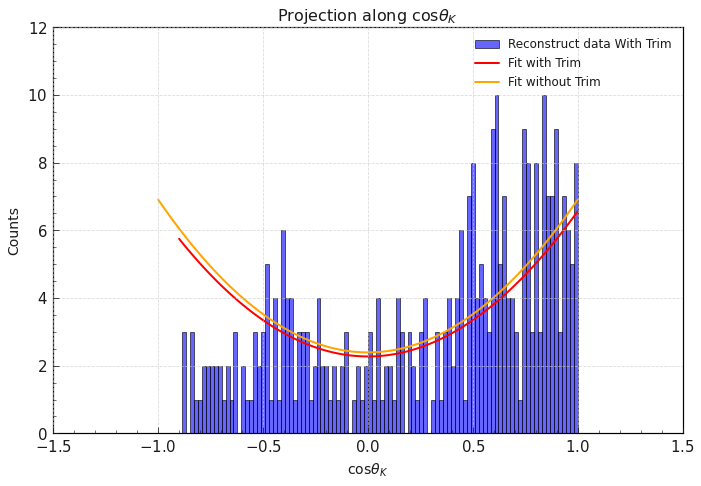

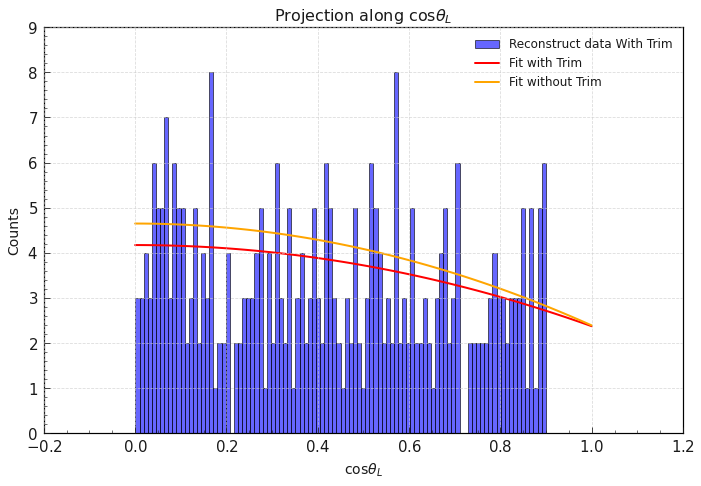

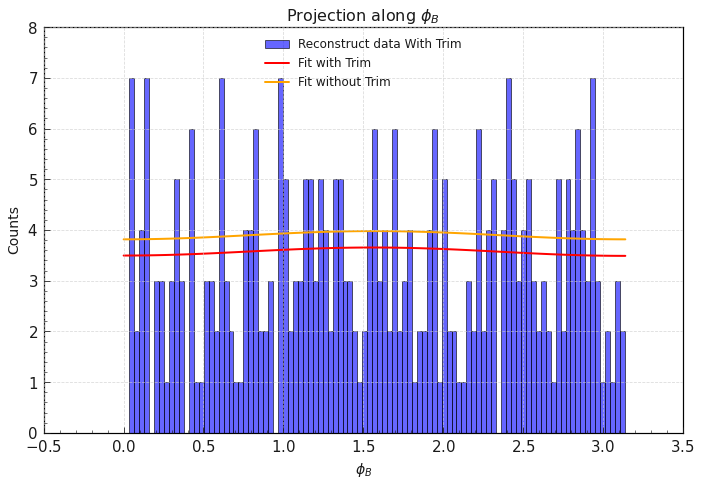

In [6]:
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt

def process_and_plot(mc_ele_signal_data_with_trim_fold, pdf_fit_signal_with_trim_gr):
    # Define ranges
    cosTheta_K_range_with_trim = np.linspace(-0.9, 1.0, 100)  # Range for cosTheta_K with trim
    cosTheta_K_range_without_trim = np.linspace(-1.0, 1.0, 100)  # Range for cosTheta_K without trim
    cosTheta_L_range = np.linspace(0, 1.0, 100)
    phi_B_range = np.linspace(0, np.pi, 100)
    
    # Create grids for with trim
    cosTheta_K_grid_with_trim, cosTheta_L_grid, phi_B_grid = np.meshgrid(cosTheta_K_range_with_trim, cosTheta_L_range, phi_B_range)
    points_with_trim = np.vstack([cosTheta_K_grid_with_trim.flatten(), cosTheta_L_grid.flatten(), phi_B_grid.flatten()]).T

    # Create grids for without trim
    cosTheta_K_grid_without_trim,cosTheta_L_grid_without_trim, phi_B_grid_without_trim= np.meshgrid(cosTheta_K_range_without_trim, cosTheta_L_range, phi_B_range)
    points_without_trim = np.vstack([cosTheta_K_grid_without_trim.flatten(), cosTheta_L_grid_without_trim.flatten(), phi_B_grid_without_trim.flatten()]).T

        
    # PDF values without trim
    pdf_values_gr_without_trim = pdf_fit_signal_with_trim_gr.pdf(points_without_trim).numpy().reshape(cosTheta_K_grid_without_trim.shape)
    integrated_pdf_total_without_trim = simps(simps(simps(pdf_values_gr_without_trim, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range_without_trim, axis=0)
    
    # PDF values with trim
    pdf_values_gr_with_trim = pdf_fit_signal_with_trim_gr.pdf(points_with_trim).numpy().reshape(cosTheta_K_grid_with_trim.shape)
    integrated_pdf_total_with_trim = simps(simps(simps(pdf_values_gr_with_trim, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range_with_trim, axis=0)

    # Calculate proportion of data lost
    proportion_data_lost = (integrated_pdf_total_without_trim - integrated_pdf_total_with_trim) / integrated_pdf_total_without_trim

    # Print the integrated PDF
    print(f"Integrated PDF with trim: {integrated_pdf_total_with_trim}")
    print(f"Integrated PDF without trim: {integrated_pdf_total_without_trim}")
    print(f"Proportion of data lost: {proportion_data_lost:.4f}")
    
    
    # Integration and normalization steps
    def integrate_and_normalize(pdf_values, num_events, cosTheta_K_range, cosTheta_L_range, phi_B_range):
        integrated_pdf_values_K = simps(simps(pdf_values, phi_B_range, axis=2), cosTheta_L_range, axis=1)
        pdf_values_K = integrated_pdf_values_K * num_events * np.diff(cosTheta_K_range)[0] 

        integrated_pdf_values_L = simps(simps(pdf_values, phi_B_range, axis=2), cosTheta_K_range, axis=0)
        pdf_values_L = integrated_pdf_values_L * num_events * np.diff(cosTheta_L_range)[0] 

        integrated_pdf_values_B = simps(simps(pdf_values, cosTheta_K_range, axis=1), cosTheta_L_range, axis=0)
        pdf_values_B = integrated_pdf_values_B * num_events * np.diff(phi_B_range)[0] 

        return pdf_values_K, pdf_values_L, pdf_values_B

    pdf_values_K_with_trim, pdf_values_L_with_trim, pdf_values_B_with_trim = integrate_and_normalize(pdf_values_gr_with_trim, len(mc_ele_signal_data_with_trim_fold), cosTheta_K_range_with_trim, cosTheta_L_range, phi_B_range)
    pdf_values_K_without_trim, pdf_values_L_without_trim, pdf_values_B_without_trim = integrate_and_normalize(pdf_values_gr_without_trim, len(mc_ele_signal_data_with_trim_fold), cosTheta_K_range_without_trim, cosTheta_L_range, phi_B_range)

    # Plot results
    def plot_histogram_with_fit(data_with_trim, range_with_trim, range_without_trim, pdf_values_with_trim, pdf_values_without_trim, var_name):
        plt.figure(figsize=(10, 7))

        # Plot histograms
        n_with_trim, bins_with_trim, _ = plt.hist(data_with_trim, bins=100, density=False, alpha=0.6, label='Reconstruct data With Trim', color='blue', edgecolor='black')
        
        # Plot fit lines
        plt.plot(range_with_trim, pdf_values_with_trim, color='red', lw=2, label='Fit with Trim')
        plt.plot(range_without_trim, pdf_values_without_trim, color='orange', lw=2, label='Fit without Trim')

        # Set axis labels and title
        plt.xlabel(var_name, fontsize=14)
        plt.ylabel('Counts', fontsize=14)
        plt.title(f'Projection along {var_name}', fontsize=16)

        # Add legend
        plt.legend(loc='best', fontsize=12)

        # Add grid
        plt.grid(True, linestyle='--', alpha=0.7)

        # Improve layout
        plt.tight_layout()

        # Show plot
        plt.savefig(f'Bppi0_generat_Psi_{var_name}_electron.pdf')
        plt.show()
        

    plot_histogram_with_fit(mc_ele_signal_data_with_trim_fold["cosTheta_K"], cosTheta_K_range_with_trim, cosTheta_K_range_without_trim, pdf_values_L_with_trim, pdf_values_L_without_trim, 'cos$\\theta_K$')
    plot_histogram_with_fit(mc_ele_signal_data_with_trim_fold["cosTheta_L"], cosTheta_L_range, cosTheta_L_range, pdf_values_K_with_trim, pdf_values_K_without_trim, 'cos$\\theta_L$')
    plot_histogram_with_fit(mc_ele_signal_data_with_trim_fold["phi_B"], phi_B_range, phi_B_range, pdf_values_B_with_trim, pdf_values_B_without_trim, '$\\phi_B$')


process_and_plot(mc_ele_signal_data_with_trim_fold, pdf_fit_signal_with_trim_gr)


In [17]:
def fit(label,particle_type, dataset_name, mc_label_particle_type_dataset_name_data, mc_label_particle_type_dataset_name_weight, model_type):
    
    if label == 'Mbc':
        obs_label = zfit.Space(label, limits=(5.20, 5.29))
        
    elif label == 'deltaE':
        obs_label = zfit.Space(label, limits=(-0.15, 0.15))
        
    else:
        raise ValueError(f"Unknown label: {label}")
        
    if particle_type == 'ele':
        mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
        mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight
    elif particle_type == 'mu':
        mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
        mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight

    r = round(np.random.rand(), 4)
    ratios_label_dataset_model_type = None
        

    if model_type == 'cb':
        
        # CrystalBall
        mu_particle_type_label_dataset_name_cb = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_cb_{r}", 5.279)
        sigma_particle_type_label_dataset_name_cb = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_cb_{r}", 0.005)
        alpha_particle_type_label_dataset_name_cb = zfit.Parameter(f"alpha_{particle_type}_{label}_{dataset_name}_cb_{r}", 1)
        n_particle_type_label_dataset_name_cb = zfit.Parameter(f"n_{particle_type}_{label}_{dataset_name}_cb_{r}", 4)
        
        
        label_dataset_name_model_type = zfit.pdf.CrystalBall(
                obs=obs_label, mu=mu_particle_type_label_dataset_name_cb, sigma=sigma_particle_type_label_dataset_name_cb,
                alpha=alpha_particle_type_label_dataset_name_cb, n=n_particle_type_label_dataset_name_cb)
        
    
    elif model_type == 'cb_gauss':
        # CrystalBall
        mu_particle_type_label_dataset_name_cb = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_cb_{r}", -0.0)
        sigma_particle_type_label_dataset_name_cb = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_cb_{r}", 0.09)
        alpha_particle_type_label_dataset_name_cb = zfit.Parameter(f"alpha_{particle_type}_{label}_{dataset_name}_cb_{r}", 1)
        n_particle_type_label_dataset_name_cb = zfit.Parameter(f"n_{particle_type}_{label}_{dataset_name}_cb_{r}", 2)

        label_dataset_name_cb = zfit.pdf.CrystalBall(
                obs=obs_label, mu=mu_particle_type_label_dataset_name_cb, sigma=sigma_particle_type_label_dataset_name_cb,
                alpha=alpha_particle_type_label_dataset_name_cb, n=n_particle_type_label_dataset_name_cb)

        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", -0.0)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", 0.096)

        label_dataset_name_gauss = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)

        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}",0.5)

        label_dataset_name_model_type = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_cb, label_dataset_name_gauss],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label)
        
    elif model_type == 'argus_gauss':

        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", 5.29, 5.28, 5.3)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}",-50)
        p_particle_type_label_dataset_name_argus= zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", 0.5)

        label_dataset_name_argus = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", 5.278)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", 0.005)

        label_dataset_name_gauss = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)

        label_dataset_name_model_type = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_argus,label_dataset_name_gauss],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label)
        
    elif model_type == 'poly_argus':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)

        label_dataset_name_poly = zfit.pdf.Chebyshev(
                obs=obs_label,coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])
        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", 5.289)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}",-120)
        p_particle_type_label_dataset_name_argus= zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", 0.5)

        label_dataset_name_argus = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)

        label_dataset_name_model_type = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_poly, label_dataset_name_argus],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label)
        
        
    elif model_type == 'poly_gauss':
        
        # Polynomial
        coeff0_ele_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)
        coeff1_ele_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)

        label_dataset_name_poly = zfit.pdf.Chebyshev(
                obs=obs_label,coeffs=[coeff0_ele_label_dataset_name_poly, coeff1_ele_label_dataset_name_poly])

        # Gaussian
        mu_ele_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", 0.0)
        sigma_ele_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", 0.08)

        label_dataset_name_gauss = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_ele_label_dataset_name_gauss, sigma=sigma_ele_label_dataset_name_gauss)
        
        # Fraction
        frac_ele_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)

        label_dataset_name_model_type = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_poly,label_dataset_name_gauss],
            fracs=[frac_ele_label_dataset_name_model_type],
            obs=obs_label)
        
    elif model_type == 'argus':
        
        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", 5.289)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}",-120)
        p_particle_type_label_dataset_name_argus= zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", 0.5)

        label_dataset_name_model_type = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
        
    elif model_type == 'poly':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)

        label_dataset_name_model_type = zfit.pdf.Chebyshev(obs=obs_label, coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])

    
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
        
    
    data_label_dataset_name = zfit.data.Data.from_pandas(
    mc_dataset_name_data_label,
    obs=obs_label,
    weights=mc_dataset_name_weight_label
    )
   
    nll_label_dataset_name = zfit.loss.UnbinnedNLL(model=label_dataset_name_model_type, data=data_label_dataset_name)
    minimizer_label_dataset_name = zfit.minimize.Minuit()
    result_label_dataset_name = minimizer_label_dataset_name.minimize(nll_label_dataset_name)
    
    # Extract and save the parameter values
    parameters_values = {
        "_".join(param.name.split('_')[:-1]): param.numpy() for param in label_dataset_name_model_type.get_params()
    }
    ratios_label_dataset_model_type = pd.DataFrame(parameters_values, index=[0])
    ratios_label_dataset_model_type.to_csv(f"parameter_{particle_type}_{label}_{dataset_name}_{model_type}_psi.csv", index=False)
    
    return label_dataset_name_model_type, result_label_dataset_name


#Signal
Mbc_ele_signal_cb,result_Mbc_ele_signal = fit('Mbc', 'ele', 'signal', mc_ele_signal["Mbc"],mc_ele_signal_weight,'cb')
deltaE_ele_signal_cb_gauss,result_deltaE_ele_signal = fit('deltaE', 'ele', 'signal', mc_ele_signal["deltaE"],mc_ele_signal_weight, 'cb_gauss')

#bkg
Mbc_ele_bkg_poly_argus,result_Mbc_ele_bkg = fit('Mbc', 'ele', 'bkg', mc_ele_bkg["Mbc"],mc_ele_bkg_weight, 'argus_gauss')
deltaE_ele_bkg_poly_gauss,result_deltaE_ele_bkg  = fit('deltaE', 'ele', 'bkg', mc_ele_bkg["deltaE"],mc_ele_bkg_weight, 'poly')



In [18]:
def plot_with_fit(ax,bins, data, data_weight, fitted_model, data_range, label_data, label_fit, xlabel, ylabel, title):
    # Calculate histogram
    n, bins, _ = ax.hist(data, bins=bins, weights=data_weight, density=False, alpha=0.5, label=label_data)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Calculate errors
    bin_weights = []
    for i in range(len(bins) - 1):
        bin_indices = np.where((data >= bins[i]) & (data < bins[i+1]))[0]
        bin_weights.append(data_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # De-normalization
    pdf_values = fitted_model.pdf(data_range).numpy() * sum(data_weight) * (bins[1] - bins[0])

    # Plot histogram with error bars and fitted model
    ax.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')
    ax.plot(data_range, pdf_values, 'r', label=label_fit)

    # Add labels and title
    ax.legend(fontsize=15)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_title(title, fontsize=15)
    return pdf_values

name                              value  (rounded)    at limit
------------------------------  ------------------  ----------
mu_ele_Mbc_signal_cb_0.3412                5.27902       False
sigma_ele_Mbc_signal_cb_0.3412          0.00286354       False
alpha_ele_Mbc_signal_cb_0.3412             2.97108       False
n_ele_Mbc_signal_cb_0.3412                 1.59071       False
True
name                                      value  (rounded)    at limit
--------------------------------------  ------------------  ----------
frac_ele_deltaE_signal_cb_gauss_0.0646            0.495642       False
mu_ele_deltaE_signal_cb_0.0646                 -0.00182515       False
sigma_ele_deltaE_signal_cb_0.0646                0.0110002       False
alpha_ele_deltaE_signal_cb_0.0646                 0.737097       False
n_ele_deltaE_signal_cb_0.0646                      1.16931       False
mu_ele_deltaE_signal_gauss_0.0646               -0.0146784       False
sigma_ele_deltaE_signal_gauss_0.0646             

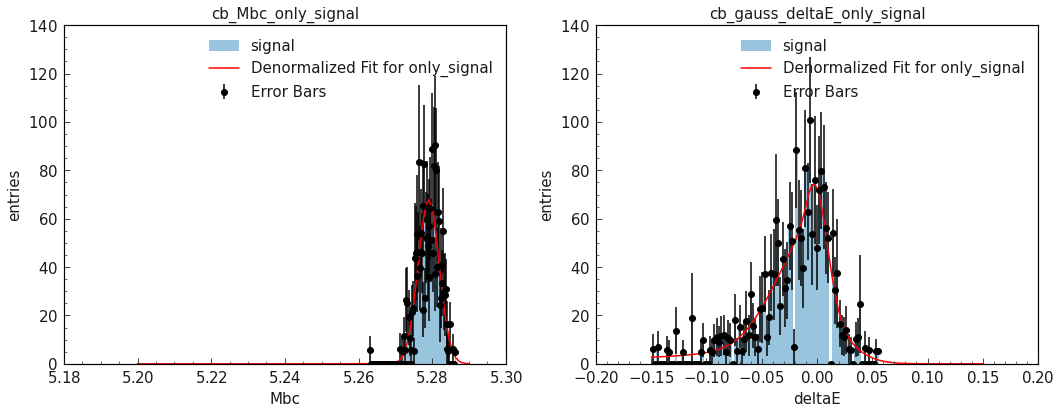

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Changed to 1 row, 2 columns

Mbc_range = np.linspace(5.20, 5.29, 100)
deltaE_range = np.linspace(-0.15, 0.15, 100)

fit_model_Mbc_only_signal = plot_with_fit(axs[0],100, mc_ele_signal["Mbc"], mc_ele_signal_weight, 
                                           Mbc_ele_signal_cb, Mbc_range, 
                                           'signal', 'Denormalized Fit for only_signal', 
                                           'Mbc', 'entries', 'cb_Mbc_only_signal')

fit_model_deltaE_only_signal = plot_with_fit(axs[1],100, mc_ele_signal["deltaE"], mc_ele_signal_weight, 
                                             deltaE_ele_signal_cb_gauss, deltaE_range, 
                                             'signal', 'Denormalized Fit for only_signal', 
                                             'deltaE', 'entries', 'cb_gauss_deltaE_only_signal')

# Adjust layout
plt.tight_layout()

# Print results if needed
print(result_Mbc_ele_signal.params)
print(result_Mbc_ele_signal.valid)
print(result_deltaE_ele_signal.params)
print(result_deltaE_ele_signal.valid)


# Show the plots
plt.show()

name                                   value  (rounded)    at limit
-----------------------------------  ------------------  ----------
frac_ele_Mbc_bkg_argus_gauss_0.9343            0.816451       False
m_ele_Mbc_bkg_argus_0.9343                      5.28719       False
c_ele_Mbc_bkg_argus_0.9343                     -55.9349       False
p_ele_Mbc_bkg_argus_0.9343                  2.63006e-05       False
mu_ele_Mbc_bkg_gauss_0.9343                     5.27975       False
sigma_ele_Mbc_bkg_gauss_0.9343               0.00443381       False
True
name                                 value  (rounded)    at limit
---------------------------------  ------------------  ----------
coeff0_ele_deltaE_bkg_poly_0.6617           -0.264406       False
coeff1_ele_deltaE_bkg_poly_0.6617           -0.104039       False
True


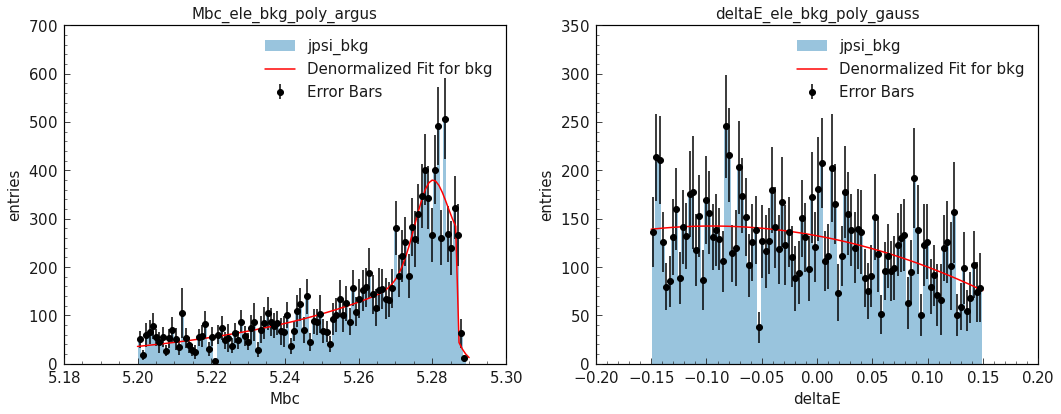

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Changed to 1 row, 2 columns

Mbc_range = np.linspace(5.20, 5.29, 100)
deltaE_range = np.linspace(-0.15, 0.15, 100)



fit_model_Mbc_jpsi_bkg = plot_with_fit(axs[0],100, mc_ele_bkg["Mbc"],mc_ele_bkg_weight, 
                                           Mbc_ele_bkg_poly_argus, Mbc_range, 
                                           'jpsi_bkg', 'Denormalized Fit for bkg', 
                                           'Mbc', 'entries', 'Mbc_ele_bkg_poly_argus')


fit_model_deltaE_jpsi_bkg = plot_with_fit(axs[1],100, mc_ele_bkg["deltaE"], mc_ele_bkg_weight, 
                                             deltaE_ele_bkg_poly_gauss, deltaE_range, 
                                             'jpsi_bkg', 'Denormalized Fit for bkg', 
                                             'deltaE', 'entries', 'deltaE_ele_bkg_poly_gauss')


# Adjust layout
plt.tight_layout()


# Print results if needed

print(result_Mbc_ele_bkg.params)
print(result_Mbc_ele_bkg.valid)
print(result_deltaE_ele_bkg.params)
print(result_deltaE_ele_bkg.valid)

# Show the plots
plt.show()



## fixed fit

In [21]:
def fit_fixed(label,particle_type, dataset_name, mc_label_particle_type_dataset_name_data, mc_label_particle_type_dataset_name_weight, model_type):
    
    if label == 'Mbc':
        obs_label = zfit.Space(label, limits=(5.20, 5.29))
        
    elif label == 'deltaE':
        obs_label = zfit.Space(label, limits=(-0.15, 0.15))
        
    else:
        raise ValueError(f"Unknown label: {label}")
        
    if particle_type == 'ele':
        mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
        mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight
    elif particle_type == 'mu':
        mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
        mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight

    r = round(np.random.rand(), 4)
    
    parameter_df = pd.read_csv(f"parameter_{particle_type}_{label}_{dataset_name}_{model_type}_psi.csv")
    
    if model_type == 'cb':
        
        # CrystalBall
        mu_particle_type_label_dataset_name_cb = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_cb_{r}", 5.279)
        sigma_particle_type_label_dataset_name_cb = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_cb"], floating=False)
        alpha_particle_type_label_dataset_name_cb = zfit.Parameter(f"alpha_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"alpha_{particle_type}_{label}_{dataset_name}_cb"], floating=False)
        n_particle_type_label_dataset_name_cb = zfit.Parameter(f"n_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"n_{particle_type}_{label}_{dataset_name}_cb"], floating=False)
      
        label_dataset_name_model_type_fixed = zfit.pdf.CrystalBall(
                obs=obs_label, mu=mu_particle_type_label_dataset_name_cb, sigma=sigma_particle_type_label_dataset_name_cb,
                alpha=alpha_particle_type_label_dataset_name_cb, n=n_particle_type_label_dataset_name_cb)
        
    elif model_type == 'cb_gauss':
        
        # CrystalBall
        mu_particle_type_label_dataset_name_cb = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_cb"], floating=False)
        sigma_particle_type_label_dataset_name_cb = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_cb"], floating=False)
        alpha_particle_type_label_dataset_name_cb = zfit.Parameter(f"alpha_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"alpha_{particle_type}_{label}_{dataset_name}_cb"], floating=False)
        n_particle_type_label_dataset_name_cb = zfit.Parameter(f"n_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"n_{particle_type}_{label}_{dataset_name}_cb"], floating=False)

        label_dataset_name_cb_fixed = zfit.pdf.CrystalBall(
                obs=obs_label, mu=mu_particle_type_label_dataset_name_cb, sigma=sigma_particle_type_label_dataset_name_cb,
                alpha=alpha_particle_type_label_dataset_name_cb, n=n_particle_type_label_dataset_name_cb)
        
        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_gauss"], floating=False)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_gauss"], floating=False)

        label_dataset_name_gauss_fixed = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}",1)

        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_cb_fixed, label_dataset_name_gauss_fixed],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label)

    elif model_type == 'poly_gauss':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f"coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}", parameter_df[f"coeff0_{particle_type}_{label}_{dataset_name}_poly"], floating=False)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f"coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}", parameter_df[f"coeff1_{particle_type}_{label}_{dataset_name}_poly"], floating=False)

        label_dataset_name_poly_fixed = zfit.pdf.Chebyshev(
                obs=obs_label,coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])

        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_gauss"], floating=False)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_gauss"], floating=False)

        label_dataset_name_gauss_fixed = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}",0.5)
        
        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_poly_fixed,label_dataset_name_gauss_fixed],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label)

    
    elif model_type == 'argus_gauss':

        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}",parameter_df[f"m_{particle_type}_{label}_{dataset_name}_argus"], floating=False)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}",parameter_df[f"c_{particle_type}_{label}_{dataset_name}_argus"], floating=False)
        p_particle_type_label_dataset_name_argus= zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"p_{particle_type}_{label}_{dataset_name}_argus"], floating=False)

        label_dataset_name_argus_fixed = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_gauss"], floating=False)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_gauss"], floating=False)

        label_dataset_name_gauss_fixed = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)

        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_argus_fixed,label_dataset_name_gauss_fixed],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label)
  
    elif model_type == 'poly_argus':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', parameter_df[f"coeff0_{particle_type}_{label}_{dataset_name}_poly"], floating=False)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', parameter_df[f"coeff1_{particle_type}_{label}_{dataset_name}_poly"], floating=False)

        label_dataset_name_poly_fixed = zfit.pdf.Chebyshev(obs=obs_label, coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])
        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"m_{particle_type}_{label}_{dataset_name}_argus"], floating=False)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"c_{particle_type}_{label}_{dataset_name}_argus"], floating=False)
        p_particle_type_label_dataset_name_argus = zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"p_{particle_type}_{label}_{dataset_name}_argus"], floating=False)

        label_dataset_name_argus_fixed = zphysics.pdf.Argus(obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)

        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)

        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_poly_fixed, label_dataset_name_argus_fixed],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label
        )
        
    elif model_type == 'argus':
        
        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", 5.28819 )
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"c_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)
        p_particle_type_label_dataset_name_argus = zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"p_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)

        label_dataset_name_model_type_fixed = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
    
        
    elif model_type == 'poly':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', parameter_df[f"coeff0_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=True)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', parameter_df[f"coeff1_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=False)

        label_dataset_name_model_type_fixed = zfit.pdf.Chebyshev(obs=obs_label, coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])
        
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
        
    
        
        
    data_label_dataset_name = zfit.data.Data.from_pandas(mc_label_particle_type_dataset_name_data, obs=obs_label, weights=mc_label_particle_type_dataset_name_weight)
    nll_label_dataset_name = zfit.loss.UnbinnedNLL(model=label_dataset_name_model_type_fixed, data=data_label_dataset_name)
    minimizer_label_dataset_name = zfit.minimize.Minuit()
    result_label_dataset_name = minimizer_label_dataset_name.minimize(nll_label_dataset_name)
        
    return label_dataset_name_model_type_fixed, result_label_dataset_name
  
#Signal
Mbc_ele_signal_cb_fixed,result_Mbc_ele_signal_fixed = fit_fixed('Mbc', 'ele', 'signal', mc_ele_signal["Mbc"],mc_ele_signal_weight,'cb')
deltaE_ele_signal_cb_gauss_fixed,result_deltaE_ele_signal_fixed = fit_fixed('deltaE', 'ele', 'signal', mc_ele_signal["deltaE"],mc_ele_signal_weight, 'cb_gauss')

#bkg
Mbc_ele_bkg_poly_argus_fixed,result_Mbc_ele_bkg_fixed = fit_fixed('Mbc', 'ele', 'bkg', mc_ele_bkg["Mbc"],mc_ele_bkg_weight, 'argus_gauss')
deltaE_ele_bkg_poly_gauss_fixed,result_deltaE_ele_bkg_fixed  = fit_fixed('deltaE', 'ele', 'bkg', mc_ele_bkg["deltaE"],mc_ele_bkg_weight, 'poly')

 
print(result_Mbc_ele_signal_fixed.params)
print(result_Mbc_ele_signal_fixed.valid)
print(result_deltaE_ele_signal_fixed.params)
print(result_deltaE_ele_signal_fixed.valid)
print(result_Mbc_ele_bkg_fixed.params)
print(result_Mbc_ele_bkg_fixed.valid)
print(result_deltaE_ele_bkg_fixed.params)
print(result_deltaE_ele_bkg_fixed.valid)
''' 
return label_dataset_name_model_type_fixed
   
     
  
#Signal
Mbc_ele_signal_cb_fixed= fit_fixed('Mbc', 'ele', 'signal', mc_ele_signal["Mbc"],mc_ele_signal_weight,'cb')
deltaE_ele_signal_cb_gauss_fixed= fit_fixed('deltaE', 'ele', 'signal', mc_ele_signal["deltaE"],mc_ele_signal_weight, 'cb_gauss')

#bkg
Mbc_ele_bkg_poly_argus_fixed= fit_fixed('Mbc', 'ele', 'bkg', mc_ele_bkg["Mbc"],mc_ele_bkg_weight, 'argus_gauss')
deltaE_ele_bkg_poly_gauss_fixed= fit_fixed('deltaE', 'ele', 'bkg', mc_ele_bkg["deltaE"],mc_ele_bkg_weight, 'poly_gauss')

#Continuum_bkg
Mbc_ele_Continuum_bkg_poly_fixed= fit_fixed('Mbc','ele', 'Continuum_bkg',  mc_ele_Continuum_bkg["Mbc"],mc_ele_Continuum_bkg_weight,'poly')
deltaE_ele_Continuum_bkg_poly_gauss_fixed = fit_fixed('deltaE','ele', 'Continuum_bkg',  mc_ele_Continuum_bkg["deltaE"],mc_ele_Continuum_bkg_weight,'poly_gauss')

'''
  


name                           value  (rounded)    at limit
---------------------------  ------------------  ----------
mu_ele_Mbc_signal_cb_0.5603             5.27902       False
True
name                                     value  (rounded)    at limit
-------------------------------------  ------------------  ----------
frac_ele_deltaE_signal_cb_gauss_0.932            0.495468       False
True
name                                   value  (rounded)    at limit
-----------------------------------  ------------------  ----------
frac_ele_Mbc_bkg_argus_gauss_0.1204            0.815292       False
True
name                                 value  (rounded)    at limit
---------------------------------  ------------------  ----------
coeff0_ele_deltaE_bkg_poly_0.5332           -0.264256       False
True


' \nreturn label_dataset_name_model_type_fixed\n   \n     \n  \n#Signal\nMbc_ele_signal_cb_fixed= fit_fixed(\'Mbc\', \'ele\', \'signal\', mc_ele_signal["Mbc"],mc_ele_signal_weight,\'cb\')\ndeltaE_ele_signal_cb_gauss_fixed= fit_fixed(\'deltaE\', \'ele\', \'signal\', mc_ele_signal["deltaE"],mc_ele_signal_weight, \'cb_gauss\')\n\n#bkg\nMbc_ele_bkg_poly_argus_fixed= fit_fixed(\'Mbc\', \'ele\', \'bkg\', mc_ele_bkg["Mbc"],mc_ele_bkg_weight, \'argus_gauss\')\ndeltaE_ele_bkg_poly_gauss_fixed= fit_fixed(\'deltaE\', \'ele\', \'bkg\', mc_ele_bkg["deltaE"],mc_ele_bkg_weight, \'poly_gauss\')\n\n#Continuum_bkg\nMbc_ele_Continuum_bkg_poly_fixed= fit_fixed(\'Mbc\',\'ele\', \'Continuum_bkg\',  mc_ele_Continuum_bkg["Mbc"],mc_ele_Continuum_bkg_weight,\'poly\')\ndeltaE_ele_Continuum_bkg_poly_gauss_fixed = fit_fixed(\'deltaE\',\'ele\', \'Continuum_bkg\',  mc_ele_Continuum_bkg["deltaE"],mc_ele_Continuum_bkg_weight,\'poly_gauss\')\n\n'

In [22]:
def fit_extended_model(Mbc_only_signal_pdf, deltaE_only_signal_pdf, Mbc_bkg_pdf, deltaE_bkg_pdf, data, weights):
    
    obs_Mbc = zfit.Space('Mbc', limits=(5.20, 5.29))
    obs_deltaE = zfit.Space('deltaE', limits=(-0.15, 0.15))
    
    combined_obs = obs_Mbc*obs_deltaE
    
    # Random number for parameter names
    r = np.round(np.random.rand(), decimals=4)
    
    # Signal model
    Mbc_signal_pdf = Mbc_only_signal_pdf
    deltaE_signal_pdf = deltaE_only_signal_pdf
    
    signal_product_pdf = zfit.pdf.ProductPDF([Mbc_signal_pdf, deltaE_signal_pdf])
    signal_yield = zfit.Parameter(f"signal_yield_{r}", 1000)
    signal_extended = signal_product_pdf.create_extended(signal_yield)

    
    Mbc_background_pdf = Mbc_bkg_pdf
    deltaE_background_pdf = deltaE_bkg_pdf

    background_product_pdf = zfit.pdf.ProductPDF([Mbc_background_pdf, deltaE_background_pdf])
    background_yield = zfit.Parameter(f"background_yield_{r}", 1000)
    background_extended = background_product_pdf.create_extended(background_yield)

    # Total model sum
    total_model = zfit.pdf.SumPDF([signal_extended, background_extended])
    
    # Create a joint data for Mbc and deltaE
    combined_data = zfit.data.Data.from_pandas(data, obs=combined_obs, weights=weights)

    # Create an extended NLL for the model and data
    nll = zfit.loss.ExtendedUnbinnedNLL(model=total_model, data=combined_data)

    # Minimize the NLL
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)
    
    return Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result

Signal_Mbc = mc_ele_signal["Mbc"]
Signal_deltaE = mc_ele_signal["deltaE"]

Background_Mbc = mc_ele_bkg["Mbc"]
Background_deltaE = mc_ele_bkg["deltaE"]

Signal_total = pd.concat([Signal_Mbc, Signal_deltaE], axis=1)
Background_total = pd.concat([Background_Mbc, Background_deltaE], axis=1)

Signal_weight = mc_ele_signal_weight
Background_weight = mc_ele_bkg_weight


Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result = fit_extended_model(
    Mbc_ele_signal_cb_fixed,deltaE_ele_signal_cb_gauss_fixed,
    Mbc_ele_bkg_poly_argus_fixed,deltaE_ele_bkg_poly_gauss_fixed,
    pd.concat([Signal_total, Background_total]),
    pd.concat([Signal_weight, Background_weight])
)

#result.hesse(name='hesse')
result.errors(name='errors')
print(result.params)
print(result.valid)

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py:585: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  warnings.warn(
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name                                     value  (rounded)               errors    at limit
-------------------------------------  ------------------  -------------------  ----------
signal_yield_0.3001                                2254.2  -     74   +     74       False
background_yield_0.3001                           12288.4  -1.2e+02   +1.3e+02       False
mu_ele_Mbc_signal_cb_0.5603                       5.27926  -9.6e-05   + 0.0001       False
frac_ele_deltaE_signal_cb_gauss_0.932             0.50251  -  0.055   +  0.054       False
frac_ele_Mbc_bkg_argus_gauss_0.1204              0.827078  - 0.0077   + 0.0077       False
coeff0_ele_deltaE_bkg_poly_0.5332               -0.266728  -  0.016   +  0.016       False
True


In [25]:
from uncertainties import ufloat
def process_fit_and_mc_results(result, signal_extended, background_extended, 
                               mc_mu_signal_weight, mc_mu_bkg_weight):
    # Extract and round yield values from fit results
    signal_yield_value = result.params[signal_extended.get_yield()]['value']
    background_yield_value = result.params[background_extended.get_yield()]['value']
    
    signal_event_fit = round(signal_yield_value, 3)
    bkg_event_fit = round(background_yield_value, 3)
    
    mc_mu_signal_weight = mc_mu_signal_weight
    mc_mu_bkg_weight = mc_mu_bkg_weight

    # Parameters from data
    mc_mu_signal_MC = round(sum(mc_mu_signal_weight), 3)
    mc_mu_bkg_MC = round(sum(mc_mu_bkg_weight), 3)

    # Print fit results
    print("Results from Fit:")
    print("Signal Events =", signal_event_fit)
    print("Background Events =", bkg_event_fit)
    print()
    
    # Print MC data results
    print("Results from MC Data:")
    print("Signal Events in MC Data =", mc_mu_signal_MC)
    print("Background Events in MC Data =", mc_mu_bkg_MC)
    print()
    
    # Calculate and print differences
    errors_sig_events = mc_mu_signal_MC - signal_event_fit
    errors_bkg_events = mc_mu_bkg_MC - bkg_event_fit
    print("Signal Events different =", round(errors_sig_events, 3))
    print("Background Events different =", round(errors_bkg_events, 3))
    
    # Calculate signal yield uncertainty
    signal_yield_errors = result.params[signal_extended.get_yield()]['errors']
    signal_yield_error = (signal_yield_errors['upper'] - signal_yield_errors['lower']) / 2
    signal_yield_with_uncertainty = ufloat(signal_yield_value, signal_yield_error)
    
    # Adjust signal yield for percentage change
    adjusted_signal_yield_with_uncertainty = signal_yield_with_uncertainty* (1 + 0.08)  
    
    # Constants for branching ratio calculation
    cross_section_nb = 0.5346e-9
    luminosity_nb = 368.4e+15
    N_bb_mesons = cross_section_nb * (4 * luminosity_nb)
    B_Psi_ee = ufloat(7.94e-3, 0.22e-3) 
    B_K_to_K_pi = (ufloat(99.754, 0.021) / 100) * 1 / 3  # Divide by 100 and then multiply by 2/3
    
    
    # Calculate and print branching ratio from fit results
    BR_MC = adjusted_signal_yield_with_uncertainty / ((2 * N_bb_mesons)*B_Psi_ee*B_K_to_K_pi)
    central_value = 6.7e-4
    average_uncertainty = 1.4e-4
    BR_PDG = ufloat(central_value, average_uncertainty)
    print("B _to_Psi(ee)_and_K*_Branching_ratio:", BR_MC)
    print("B _to_Psi(ee)_and_K*_Branching_ratio_from_PDG:", BR_PDG)
    
    # Calculate adjusted signal yield for MC data
    adjusted_signal_yield_MC = mc_mu_signal_MC * (1 + 0.08) 
    BR_MC_from_MC = adjusted_signal_yield_MC /((2 * N_bb_mesons)*B_Psi_ee*B_K_to_K_pi)
    print("B _to_Psi(ee)_and_K*_Branching_ratio (MC Data):", BR_MC_from_MC)
    print("B _to_Psi(ee)_and_K*_Branching_ratio_from_PDG:", BR_PDG)

# Example usage (replace with actual variables)
process_fit_and_mc_results(result, signal_extended, background_extended, mc_ele_signal_weight, mc_ele_bkg_weight)



Results from Fit:
Signal Events = 2254.205
Background Events = 12288.366

Results from MC Data:
Signal Events in MC Data = 2102.264
Background Events in MC Data = 12441.755

Signal Events different = -151.941
Background Events different = 153.389
B _to_Psi(ee)_and_K*_Branching_ratio: 0.000542+/-0.000023
B _to_Psi(ee)_and_K*_Branching_ratio_from_PDG: 0.00067+/-0.00014
B _to_Psi(ee)_and_K*_Branching_ratio (MC Data): 0.000505+/-0.000014
B _to_Psi(ee)_and_K*_Branching_ratio_from_PDG: 0.00067+/-0.00014


In [ ]:
signal_yield_value = result.params[signal_extended.get_yield()]['value']
background_yield_value = result.params[background_extended.get_yield()]['value']

# Round the values
signal_event_fit = round(signal_yield_value, 3)
bkg_event_fit = round(background_yield_value, 3)

mc_ele_signal_weight = mc_ele_signal_weight
mc_ele_bkg_weight = pd.concat([mc_ele_Bmeson_bkg_weight,mc_ele_Continuum_bkg_weight])

# Parameters from data
mc_ele_signal_MC_data = round(sum(mc_ele_signal_weight), 3)
mc_ele_bkg_MC_data = round(sum(mc_ele_bkg_weight), 3)

# Print the results
print("Results from Fit:")
print("Signal Events =", signal_event_fit)
print("Background Events =", bkg_event_fit)
print()

print("Results from MC Data:")
print("Signal Events in MC Data =", mc_ele_signal_MC_data)
print("Background Events in MC Data =", mc_ele_bkg_MC_data)
print()

errors_sig_events = signal_event_fit-mc_ele_signal_MC_data
print("Signal Events different =", round(errors_sig_events, 3))

errors_bkg_events = bkg_event_fit - mc_ele_bkg_MC_data
print("Background Events different=", round(errors_bkg_events, 3))


In [ ]:
import numpy as np
from uncertainties import ufloat

# Extract signal yield and its error from fit result
signal_yield = result.params[signal_extended.get_yield()]['value']
signal_yield_errors = result.params[signal_extended.get_yield()]['errors']

# Calculate the standard deviation from the given error range
signal_yield_error = (signal_yield_errors['upper'] - signal_yield_errors['lower']) / 2


# Create an ufloat for the signal yield with its uncertainty
signal_yield_with_uncertainty = ufloat(signal_yield, signal_yield_error)

# Adjust the signal yield for the percentage change (18.53%)
adjusted_signal_yield_with_uncertainty = signal_yield_with_uncertainty * (1 + 0.0816)

# Constants
cross_section_nb = 0.5346e-9  # Cross-section in nanobarns
luminosity_nb = 368.4e+15  # Luminosity in femtobarns

# Calculate the number of B mesons
N_bb_mesons = cross_section_nb * (4 * luminosity_nb)

# Branching ratio calculation
B_Psi_to_ee = ufloat(7.94e-3, 0.22e-3)  
B_K_to_K_pi = (ufloat(99.754, 0.021) / 100) * 2 / 3  # Divide by 100 and then multiply by 2/3

BR_MC = adjusted_signal_yield_with_uncertainty / ((2 * N_bb_mesons)*B_Psi_to_ee*B_K_to_K_pi)

BR_PDG = ufloat(5.9e-4, 0.4e-4)

# Print results
print("B _to_ee_and_K*_for_electron_Branching_ratio:", BR_MC)
print("B _to_ee_and_K*_Branching_ratio_from_PDG:", BR_PDG)



In [ ]:
signal_yield_with_uncertainty*0.0816

In [ ]:
import numpy as np
from uncertainties import ufloat


# Create an ufloat for the signal yield with its uncertainty
signal_yield_with_uncertainty = sum(mc_ele_signal_weight)

# Adjust the signal yield for the percentage change (18.53%)
adjusted_signal_yield_with_uncertainty = signal_yield_with_uncertainty * (1 + 0.0816)

# Constants
cross_section_nb = 0.5346e-9  # Cross-section in nanobarns
luminosity_nb = 368.4e+15  # Luminosity in femtobarns

# Calculate the number of B mesons
N_bb_mesons = cross_section_nb * (4 * luminosity_nb)

# Branching ratio calculation
B_Psi_to_ee = ufloat(7.94e-3, 0.22e-3)  
B_K_to_K_pi = (ufloat(99.754, 0.021) / 100) * 2 / 3  # Divide by 100 and then multiply by 2/3

BR_MC = adjusted_signal_yield_with_uncertainty / ((2 * N_bb_mesons)*B_Psi_to_ee*B_K_to_K_pi)

BR_PDG = ufloat(5.9e-4, 0.4e-4)

# Print results
print("B _to_ee_and_K*_for_electron_Branching_ratio:", BR_MC)
print("B _to_ee_and_K*_Branching_ratio_from_PDG:", BR_PDG)

In [ ]:
signal_yield_with_uncertainty*0.0816

In [ ]:
def plot_variable(ax, variable, data_only_signal,Bmeson_bkg,Continuum_bkg, weight_signal, weight_Bmeson_bkg,weight_Continuum_bkg, 
                  signal_pdf, background_pdf, label_signal, label_background):    

    signal_df = pd.concat([data_only_signal[variable]])
    bkg_df = pd.concat([Bmeson_bkg[variable],Continuum_bkg[variable]])
    
    df_total = pd.concat([signal_df,bkg_df])
    
    signal_weight = weight_signal
    bkg_weight = pd.concat([weight_Bmeson_bkg,weight_Continuum_bkg])
    
    total_weight=pd.concat([signal_weight, bkg_weight])
    
    r = np.round(np.random.rand(), decimals=4)


    # Define bin edges and x_fit
    if variable == "Mbc":
        bin_edges = np.linspace(5.20, 5.288, 100)
        x_fit = np.linspace(5.20, 5.288, 100)
    elif variable == "deltaE":
        bin_edges = np.linspace(-0.15, 0.15, 100)
        x_fit = np.linspace(-0.15, 0.15, 100)

    
    # Plot the total fit
    n, bins, _ = ax.hist(df_total, bins=bin_edges, weights=total_weight, density=False, color='green',alpha=0.3,label="total Data")
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    y_background_fit = background_pdf.pdf(x_fit) * sum(bkg_weight ) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_background_fit, label="Background", linestyle="--", color="yellow", linewidth=2)
    
    y_signal_fit = signal_pdf.pdf(x_fit) * sum(signal_weight) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_signal_fit, label="Signal", linestyle="--", color="crimson", linewidth=2)
    
    # Calculate errors
    bin_weights = []
    for i in range(len(bins) - 1):
        bin_indices = np.where((df_total >= bins[i]) & (df_total < bins[i+1]))[0]
        bin_weights.append(total_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # Plot histogram with error bars and fitted model
    ax.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')

    # Plot the total fit with error bars
    y_total_fit = y_signal_fit + y_background_fit 
    ax.plot(x_fit, y_total_fit, label="Total", color="royalblue", linewidth=2)

    # Add labels and legend
    ax.set_xlabel(variable)
    ax.set_ylabel('Counts')
    ax.set_title('')
    ax.legend()

#Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Mbc
plot_variable(axs[0], "Mbc", mc_ele_signal,mc_ele_Bmeson_bkg,mc_ele_Continuum_bkg, mc_ele_signal_weight, mc_ele_Bmeson_bkg_weight,mc_ele_Continuum_bkg_weight, 
              Mbc_signal_pdf, Mbc_background_pdf, "Signal Data", "Bkg Data")

# Plot deltaE
plot_variable(axs[1], "deltaE", mc_ele_signal,mc_ele_Bmeson_bkg,mc_ele_Continuum_bkg, mc_ele_signal_weight, mc_ele_Bmeson_bkg_weight,mc_ele_Continuum_bkg_weight, 
              deltaE_signal_pdf, deltaE_background_pdf, "Signal Data", "Bkg Data")
# Adjust layout
plt.tight_layout()

# Show plot
#plt.savefig('q2regs_1 for electron.png')
plt.show()

In [ ]:
def plot_variable(ax, variable, data_only_signal,Bmeson_bkg,Continuum_bkg, weight_signal, weight_Bmeson_bkg,weight_Continuum_bkg, 
                  signal_pdf, background_pdf, label_signal, label_background):    

    signal_df = pd.concat([data_only_signal[variable]])
    bkg_df = pd.concat([Bmeson_bkg[variable],Continuum_bkg[variable]])
    
    df_total = pd.concat([signal_df,bkg_df])
    
    signal_weight = weight_signal
    bkg_weight = pd.concat([weight_Bmeson_bkg,weight_Continuum_bkg])
    
    total_weight=pd.concat([signal_weight, bkg_weight])
    
    r = np.round(np.random.rand(), decimals=4)


    # Define bin edges and x_fit
    if variable == "Mbc":
        bin_edges = np.linspace(5.20, 5.288, 100)
        x_fit = np.linspace(5.20, 5.288, 100)
    elif variable == "deltaE":
        bin_edges = np.linspace(-0.15, 0.15, 100)
        x_fit = np.linspace(-0.15, 0.15, 100)

    # Plot the background component
    ax.hist(bkg_df, bins=bin_edges, weights= bkg_weight, density=False, color='blue', alpha=0.3, label=label_background)
    y_background_fit = background_pdf.pdf(x_fit) * sum(bkg_weight ) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_background_fit, label="Background", linestyle="--", color="yellow", linewidth=2)

    # Plot the signal component
    ax.hist(signal_df, bins=bin_edges, weights=signal_weight, density=False, color='red',alpha=0.3,label=label_signal)
    y_signal_fit = signal_pdf.pdf(x_fit) * sum(signal_weight) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_signal_fit, label="Signal", linestyle="--", color="crimson", linewidth=2)

    # Plot the total fit
    n, bins, _ = ax.hist(df_total, bins=bin_edges, weights=total_weight, density=False, color='green',alpha=0.3,label="total Data")
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate errors
    bin_weights = []
    for i in range(len(bins) - 1):
        bin_indices = np.where((df_total >= bins[i]) & (df_total < bins[i+1]))[0]
        bin_weights.append(total_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # Plot histogram with error bars and fitted model
    ax.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')

    # Plot the total fit with error bars
    y_total_fit = y_signal_fit + y_background_fit 
    ax.plot(x_fit, y_total_fit, label="Total", color="royalblue", linewidth=2)

    # Add labels and legend
    ax.set_xlabel(variable)
    ax.set_ylabel('Counts')
    ax.set_title('')
    ax.legend()

#Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Mbc
plot_variable(axs[0], "Mbc", mc_ele_signal,mc_ele_Bmeson_bkg,mc_ele_Continuum_bkg, mc_ele_signal_weight, mc_ele_Bmeson_bkg_weight,mc_ele_Continuum_bkg_weight, 
              Mbc_signal_pdf, Mbc_background_pdf, "Signal Data", "Bkg Data")

# Plot deltaE
plot_variable(axs[1], "deltaE", mc_ele_signal,mc_ele_Bmeson_bkg,mc_ele_Continuum_bkg, mc_ele_signal_weight, mc_ele_Bmeson_bkg_weight,mc_ele_Continuum_bkg_weight, 
              deltaE_signal_pdf, deltaE_background_pdf, "Signal Data", "Bkg Data")
# Adjust layout
plt.tight_layout()

# Show plot
#plt.savefig('q2regs_1 for electron.png')
plt.show()

In [ ]:
def plot_variable(ax, variable, data_only_signal,Bmeson_bkg,Continuum_bkg, weight_signal, weight_Bmeson_bkg,weight_Continuum_bkg, 
                  signal_pdf, background_pdf, label_signal, label_background):    

    signal_df = pd.concat([data_only_signal[variable]])
    bkg_df = pd.concat([Bmeson_bkg[variable],Continuum_bkg[variable]])
    
    df_total = pd.concat([signal_df,bkg_df])
    
    signal_weight = weight_signal
    bkg_weight = pd.concat([weight_Bmeson_bkg,weight_Continuum_bkg])
    
    total_weight=pd.concat([signal_weight, bkg_weight])
    
    r = np.round(np.random.rand(), decimals=4)


    # Define bin edges and x_fit
    if variable == "Mbc":
        bin_edges = np.linspace(5.20, 5.288, 100)
        x_fit = np.linspace(5.20, 5.288, 100)
    elif variable == "deltaE":
        bin_edges = np.linspace(-0.15, 0.15, 100)
        x_fit = np.linspace(-0.15, 0.15, 100)

    # Plot the background component
    #ax.hist(bkg_df, bins=bin_edges, weights= bkg_weight, density=False, color='blue', alpha=0.3, label=label_background)
    y_background_fit = background_pdf.pdf(x_fit) * sum(bkg_weight ) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_background_fit, label="Background", linestyle="--", color="blue", linewidth=2)

    # Plot the signal component
    #ax.hist(signal_df, bins=bin_edges, weights=signal_weight, density=False, color='red',alpha=0.3,label=label_signal)
    y_signal_fit = signal_pdf.pdf(x_fit) * sum(signal_weight) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_signal_fit, label="Signal", linestyle="--", color="red", linewidth=2)

    # Plot the total fit
    n, bins, _ = ax.hist(df_total, bins=bin_edges, weights=total_weight, density=False, color='white',alpha=0.3)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate errors
    bin_weights = []
    for i in range(len(bin_edges) - 1):
        bin_indices = np.where((df_total >= bins[i]) & (df_total < bins[i+1]))[0]
        bin_weights.append(total_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # Plot histogram with error bars and fitted model
    ax.errorbar(bin_centers, n, yerr=errors, fmt='o',markersize=5, color='black', label='data')

    # Plot the total fit with error bars
    y_total_fit = y_signal_fit + y_background_fit 
    ax.plot(x_fit, y_total_fit, label="Fit", color="black", linewidth=2)

    # Add labels and legend
    ax.set_xlabel(variable)
    ax.set_ylabel('Counts')
    ax.set_title('')
    ax.legend()

#Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Mbc
plot_variable(axs[0], "Mbc", mc_ele_signal,mc_ele_Bmeson_bkg,mc_ele_Continuum_bkg, mc_ele_signal_weight, mc_ele_Bmeson_bkg_weight,mc_ele_Continuum_bkg_weight, 
              Mbc_signal_pdf, Mbc_background_pdf, "Signal Data", "Bkg Data")

# Plot deltaE
plot_variable(axs[1], "deltaE", mc_ele_signal,mc_ele_Bmeson_bkg,mc_ele_Continuum_bkg, mc_ele_signal_weight, mc_ele_Bmeson_bkg_weight,mc_ele_Continuum_bkg_weight, 
              deltaE_signal_pdf, deltaE_background_pdf, "Signal Data", "Bkg Data")
# Adjust layout
plt.tight_layout()

# Show plot
#plt.savefig('q2regs_1 for electron.png')
plt.show()

/tmp/ipykernel_1738670/1179290172.py:58: RuntimeWarning: divide by zero encountered in true_divide
  pulls = (n - y_total_fit_binned) / errors


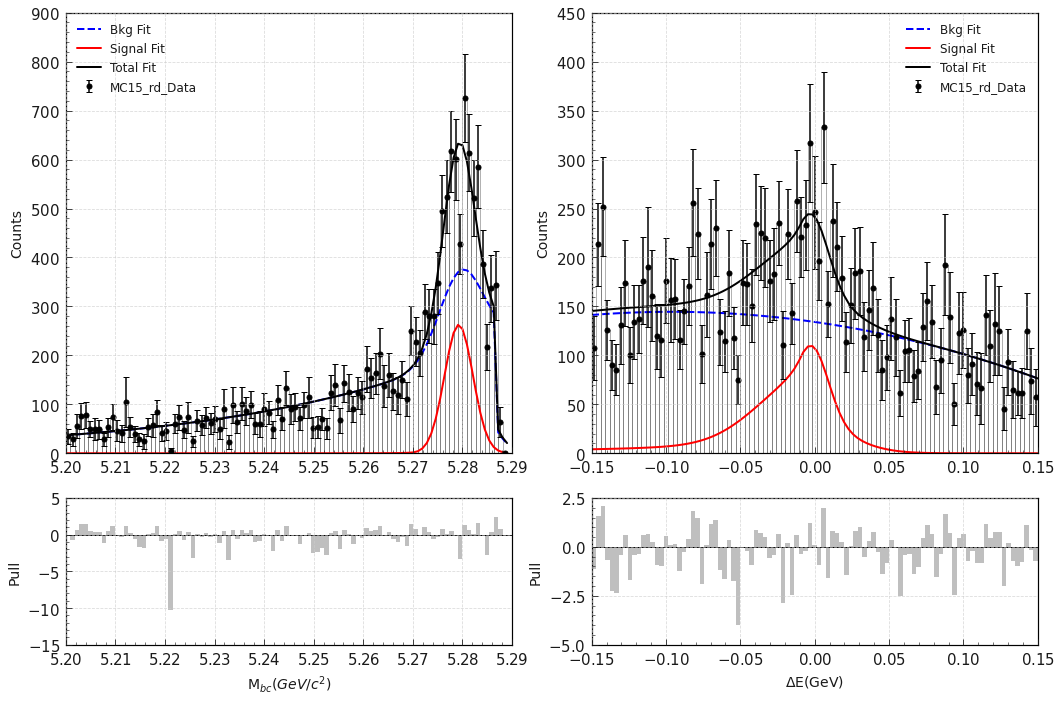

In [26]:
def plot_variable(ax, ax_pull, variable, data_signal, bkg, weight_signal, weight_bkg, 
                  signal_pdf, background_pdf, label_signal, label_background, xaxis):    

    signal_df = data_signal[variable]
    bkg_df = bkg[variable]
    
    df_total = pd.concat([signal_df, bkg_df])
    
    signal_weight = weight_signal
    bkg_weight = weight_bkg
    
    total_weight = pd.concat([signal_weight, bkg_weight])
    
    # Define bin edges and x_fit
    if variable == "Mbc":
        bin_edges = np.linspace(5.20, 5.289, 100)
        x_fit = np.linspace(5.20, 5.289, 100)
        ax.set_xlim(5.20, 5.29)
        ax_pull.set_xlim(5.20, 5.29)
        
    elif variable == "deltaE":
        bin_edges = np.linspace(-0.15, 0.15, 100)
        x_fit = np.linspace(-0.15, 0.15, 100)
        ax.set_xlim(-0.15, 0.15)
        ax_pull.set_xlim(-0.15, 0.15)


    # Plot the background component
    y_background_fit = background_pdf.pdf(x_fit) * sum(bkg_weight) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_background_fit, label=label_background, linestyle="--", color="blue", linewidth=2)

    # Plot the signal component
    y_signal_fit = signal_pdf.pdf(x_fit) * sum(signal_weight) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_signal_fit, label=label_signal, linestyle="-", color="red", linewidth=2)

    # Plot the total fit
    n, bins, _ = ax.hist(df_total, bins=bin_edges, weights=total_weight, density=False, color='white', alpha=0.3, edgecolor='black')
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate errors
    bin_weights = []
    for i in range(len(bin_edges) - 1):
        bin_indices = np.where((df_total >= bins[i]) & (df_total < bins[i+1]))[0]
        bin_weights.append(total_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # Plot histogram with error bars and fitted model
    ax.errorbar(bin_centers, n, yerr=errors, fmt='o', markersize=5, color='black', label='MC15_rd_Data', capsize=3)

    # Plot the total fit with error bars
    y_total_fit = y_signal_fit + y_background_fit
    
    # Adjust y_total_fit to match the number of bins
    y_total_fit_binned = np.interp(bin_centers, x_fit, y_total_fit)
    ax.plot(x_fit, y_total_fit, label="Total Fit", color="black", linewidth=2)

    # Calculate pull and plot
    pulls = (n - y_total_fit_binned) / errors
    ax_pull.bar(bin_centers, pulls, width=np.diff(bin_edges), align='center', alpha=0.5, color='gray')
    ax_pull.axhline(0, color='black', linewidth=1)
    ax_pull.set_xlabel(xaxis, fontsize=14)
    ax_pull.set_ylabel('Pull', fontsize=14)
    ax_pull.grid(True, linestyle='--', alpha=0.7)
    
    # Add labels and legend
    #ax.set_xlabel(xaxis, fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot Mbc
plot_variable(axs[0, 0], axs[1, 0], "Mbc", mc_ele_signal, mc_ele_bkg,mc_ele_signal_weight, mc_ele_bkg_weight,
              Mbc_signal_pdf, Mbc_background_pdf, "Signal Fit", "Bkg Fit", "M$_{bc}(GeV/c^2)$")

# Plot deltaE
plot_variable(axs[0, 1], axs[1, 1], "deltaE", mc_ele_signal, mc_ele_bkg,mc_ele_signal_weight, mc_ele_bkg_weight, 
              deltaE_signal_pdf, deltaE_background_pdf, "Signal Fit", "Bkg Fit", '$\\Delta$E(GeV)')

# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('Bpeepi0_Psi_decay_ee.pdf')
plt.show()
